In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions.tools import *
from datetime import datetime
import os

## Global variables

In [2]:
path_history = 'models_neural_network/history_V1.json'
vocabulary_path = './data/vocabulary/vocabulary.json'
path_ids_labels = './data/ids_labels/dict_label_id.json'
path_vector = './data/vectorized/vector_train.pkl'

# Clasifier path
clasifier_path = './model_clasifier/'
# Model path
model_clasifier = clasifier_path + 'my_model_V1.h5'
# Model information path:
model_clasifier_info = clasifier_path + 'model_info.json'

# Training paths
train_name = 'train_1'
model_clasifier_train_path = clasifier_path + 'train/'
model_clasifier_history_path_train = model_clasifier_train_path + train_name + '/'
history_path = model_clasifier_history_path_train + 'history.json'
train_epochs_image_path = model_clasifier_history_path_train + 'epochs.png'
train_dict_label_id_path = model_clasifier_history_path_train + 'dict_label_id.json'
train_vector_path = model_clasifier_history_path_train + 'vector_train.pkl'
train_vocabulary_path = model_clasifier_history_path_train + 'vocabulary.json'

# Test paths
test_name = 'test_1'
model_clasifier_test_path = clasifier_path + 'test/'
model_clasifier_results_path_test = model_clasifier_test_path + test_name + '/'
# Results of the test
prediction_dataset = model_clasifier_results_path_test + 'prediction.csv'
correct_prediction_dataset = model_clasifier_results_path_test + 'correct_prediction.csv'
incorrect_prediction_dataset = model_clasifier_results_path_test + 'incorrect_prediction.csv'
# Resulting images of the test
images_test_path = model_clasifier_results_path_test + 'Images/'
test_distribution_image = images_test_path + 'distribution.png'
test_accuracy_image = images_test_path + 'accuracy.png'
test_correct_image = images_test_path + 'correct.png'
test_incorrect_image = images_test_path + 'incorrect.png'

In [3]:
test_query = "SELECT * FROM INFOJOBS WHERE FECHA_PUBLICACION >= '2021-07-01' AND FECHA_PUBLICACION <= '2021-08-31'"
df_test = pd.read_csv('data/actual/df_test_julio_agosto_no_asunto_filtro_5_palabras.csv')
train_query = "SELECT * FROM INFOJOBS"
df_train = pd.read_csv('data/previous/df_train_test.csv')

### Train, vocabulary and id->label

In [4]:
vector, vocabulary = load_vector_columns(train_vector_path, train_vocabulary_path)
if vector is None:
    vector, vocabulary = create_vector_columns(df_train)
    save_vector_columns(vector, path_vector)
if vocabulary is None:
    vector, vocabulary = create_vector_columns(vector)
    save_vocabulary(vocabulary, vocabulary_path)
train_ids = df_train['ID_PUESTO_ESCO_ULL']
dict_label_ids = load_dict_label_ids(train_dict_label_id_path)
if dict_label_ids is None:
    dict_label_ids = create_dict_label_ids(train_ids)
    save_dict_label_ids(dict_label_ids, path_ids_labels)
train_labels = cast_id_to_labels(train_ids, dict_label_ids)

### Test

In [5]:
# Drop the key 'dimension' from vocabulary
vector_test = convert_TEST_to_vector(df_test, vocabulary)
test_ids = df_test['ID_PUESTO_ESCO_ULL']
test_labels = cast_id_to_labels(test_ids, dict_label_ids)

### Load model or train and save

In [6]:
import tensorflow as tf
from tensorflow import keras
from functions.model import model_creation, model_train, model_save, model_load, history_save, history_load

# Assuming you have loaded your training data as train_labels and vector
# train_labels is a 1D array of class labels

input_dim = get_vocabulary_dimension(vocabulary)
num_classes = get_dimension_labels(dict_label_ids)

# Convert the Pandas Series of arrays into a NumPy array
vector_array = np.vstack(vector)
train_labels_array = np.array(train_labels)

model = model_load(model_clasifier)
history_data = history_load(history_path)
if model is None:
    model = model_creation(input_dim, num_classes)
    model, history = model_train(model, train_query, vector_array, train_labels_array, epochs=10, batch_size=8, validation_split=0.2, verbose=1, balance_data=True)
    # model = backpropagation(epochs=10, model=model, learning_rate=0.01, vector_array=vector_array, label_array=train_labels_array)
    model_save(model, model_clasifier)
# if history_data is None:
#     history_data = history_save(history, path_history)
    # # Plotting Accuracy
    # plt.plot(history_data['accuracy'], label='Training Accuracy')
    # plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.title('Training and Validation Accuracy')
    # plt.legend()
    # plt.show()

2023-08-21 11:21:06.013005: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 11:21:07.165151: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 11:21:07.184386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 11:21:13.145928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-21 11:21:37.053709: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38060032 exceeds 10% of free system memory.
2023-08-21 11:21:37.113874: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38060032 exceeds 10% of free system memory.
2023-08-21 11:

In [7]:
# from functions.model import model_load
# model = model_load()
prediction = model.predict(vector[0].reshape(1, -1))
print(len(prediction[0]))
# Get the index of the highest probability
predicted_label = np.argmax(prediction[0])
print(predicted_label)
# Cast the index that is a label to id
predicted_id = cast_labels_to_id([predicted_label], dict_label_ids)
print(predicted_id)

1/1 [==============================] - 0s 364ms/step
996
567
[1634]


In [8]:
vector_test_array = np.vstack(vector_test)
real_id = list(df_test['ID_PUESTO_ESCO_ULL'])
# Get the accuracy comparing the two lists predictions_id and real_id
accuracy = get_accuracy(model, vector_test_array, dict_label_ids, real_id)
# Print like a percentage and round to 2 decimals
print(f'Accuracy: {round(accuracy*100, 2)}%')
predicted_id, probability = get_predictions(model, vector_test_array, dict_label_ids)
top_predictions_id = get_top_highest_predictions(model, vector_test_array, dict_label_ids, 3)
def create_test(df_test, model, vocabulary, dict_label_ids, table_name='', batch_size=32, verbose=1):
    vector_test_array = np.vstack(convert_TEST_to_vector(df_test, vocabulary))
    real_id = list(df_test['ID_PUESTO_ESCO_ULL'])
    accuracy = get_accuracy(model, vector_test_array, dict_label_ids, real_id)
    test_name = input('Enter the name of the test: ')
        # Verify table name is not null if not ask for it with input
    if table_name == '':
        table_name = input('Enter the name of the table: ')
    test_dict = {
        'test_name': test_name,
        'table_name': table_name,
        'description': input('Enter a description of the test: '),
        'fecha_inicio': input('Enter the start date of the test: '),
        'fecha_fin': input('Enter the end date of the test: '),
        'query': input('Enter the query of the test: '),
        'test_parameters': {
            'batch_size': batch_size,
            'verbose': verbose
        },
        'fecha_test': datetime.now().strftime("%Y-%m-%d %H:%M"),
        'resultados': {
            'accuracy': accuracy,
            'loss': 1 - accuracy
        },
    }
    with open('model_info.json', 'r') as json_file:
        model_info = json.load(json_file)
    model_info['test'].append(test_dict)
    with open('model_info.json', 'w') as json_file:
        json.dump(model_info, json_file)
    return test_dict

def create_test_results(test_name, df_test, predicted_id, probability):
    df_results_id = pd.DataFrame({'REAL_ID': df_test['ID_PUESTO_ESCO_ULL'], 'PREDICTED_ID': predicted_id, 'PROBABILITY': probability, 'ID_OFERTA': df_test['ID_OFERTA']})
    df_correct = df_results_id[df_results_id['REAL_ID'] == df_results_id['PREDICTED_ID']]
    df_errors = df_results_id[df_results_id['REAL_ID'] != df_results_id['PREDICTED_ID']]
    # Create the new directory if not exists
    model_clasifier_test_path
    if not os.path.exists(model_clasifier_test_path):
        os.makedirs(model_clasifier_test_path)
    

create_test(df_test, predicted_id, probability, top_predictions_id, dict_label_ids, 'NB_multiclass_prob_class.csv')

1/1 [==============================] - 0s 113ms/step
Accuracy: 44.83%
1/1 [==============================] - 0s 27ms/step


In [9]:
df_results_id = pd.DataFrame({'REAL_ID': df_test['ID_PUESTO_ESCO_ULL'], 'PREDICTED_ID': predicted_id, 'PROBABILITY': probability, 'ID_OFERTA': df_test['ID_OFERTA']})
df_correct = df_results_id[df_results_id['REAL_ID'] == df_results_id['PREDICTED_ID']]
df_errors = df_results_id[df_results_id['REAL_ID'] != df_results_id['PREDICTED_ID']]

In [10]:
def print_probability_stats(label, min_prob, max_prob, mean_prob, df):
    print(f"{label} Probability:")
    print(f"  Min: {min_prob:.2%}")
    print(f"  Max: {max_prob:.2%}")
    print(f"  Mean: {mean_prob:.2%}")
    print(f"  Count: {df}")
    print()  # Add a newline after each set of statistics
    
# Calculate statistics for errors and correct groups
min_prob_errors = df_errors['PROBABILITY'].min()
max_prob_errors = df_errors['PROBABILITY'].max()
mean_prob_errors = df_errors['PROBABILITY'].mean()
min_prob_correct = df_correct['PROBABILITY'].min()
max_prob_correct = df_correct['PROBABILITY'].max()
mean_prob_correct = df_correct['PROBABILITY'].mean()
# Print statistics using the refactored function
print_probability_stats("Errors", min_prob_errors, max_prob_errors, mean_prob_errors, len(df_errors))
print_probability_stats("Correct", min_prob_correct, max_prob_correct, mean_prob_correct, len(df_correct))
print("  Total count: ", len(df_errors) + len(df_correct))

Errors Probability:
  Min: 41.11%
  Max: 99.81%
  Mean: 73.30%
  Count: 16

Correct Probability:
  Min: 52.62%
  Max: 100.00%
  Mean: 94.31%
  Count: 13

  Total count:  29


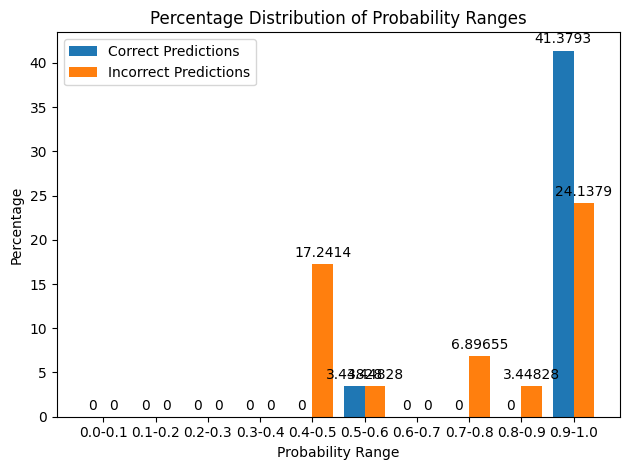

En esta gráfica se muestran de color azul, aquellas ocupaciones que se han predicho correctamente, y de color naranja, aquellas que se han predicho incorrectamente.
Los valores numéricos en el eje X representan la confianza del clasificador.
Y en el eje Y se muestra el porcentaje de predicciones que se han realizado en cada rango de confianza en base al número total de ofertas en este caso es: 29
0.0     0
0.1     0
0.2     0
0.3     0
0.4     0
0.5     1
0.6     0
0.7     0
0.8     0
0.9    12
Name: PROBABILITY, dtype: int64
0.0    0
0.1    0
0.2    0
0.3    0
0.4    5
0.5    1
0.6    0
0.7    2
0.8    1
0.9    7
Name: PROBABILITY, dtype: int64


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the probability ranges
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Assuming you have loaded the dataframes df_correct and df_errors

# DATA 1
# Categorize the probabilities into ranges and count occurrences
probability_ranges1 = pd.cut(df_correct['PROBABILITY'], bins=bins, labels=bins[:-1])
probability_counts1 = probability_ranges1.value_counts(sort=False)

# Calculate percentage distribution
percentage_distribution1 = (probability_counts1 / len(df_results_id)) * 100

# DATA 2
# Categorize the probabilities into ranges and count occurrences
probability_ranges2 = pd.cut(df_errors['PROBABILITY'], bins=bins, labels=bins[:-1])
probability_counts2 = probability_ranges2.value_counts(sort=False)

# Calculate percentage distribution
percentage_distribution2 = (probability_counts2 / len(df_results_id)) * 100

# Data for plotting
attributes = ["Correct Predictions", "Incorrect Predictions"]
percentage_data = [percentage_distribution1, percentage_distribution2]

x = np.arange(len(bins) - 1)  # the label locations
width = 0.4  # the width of the bars
multiplier = -0.5

fig, ax = plt.subplots()

for i, attribute_data in enumerate(percentage_data):
    offset = width * multiplier
    rects = ax.bar(x + offset, attribute_data, width, label=attributes[i])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Percentage')
ax.set_xlabel('Probability Range')
ax.set_title('Percentage Distribution of Probability Ranges')
ax.set_xticks(x)
ax.set_xticklabels([f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)])
ax.legend(loc='upper left')

plt.tight_layout()
# Save the plot
plt.savefig(path_static_distribution)
plt.show()
print("En esta gráfica se muestran de color azul, aquellas ocupaciones que se han predicho correctamente, y de color naranja, aquellas que se han predicho incorrectamente.")
print("Los valores numéricos en el eje X representan la confianza del clasificador.")
print("Y en el eje Y se muestra el porcentaje de predicciones que se han realizado en cada rango de confianza en base al número total de ofertas en este caso es: " + str(len(df_results_id)))
print(probability_counts1)
print(probability_counts2)

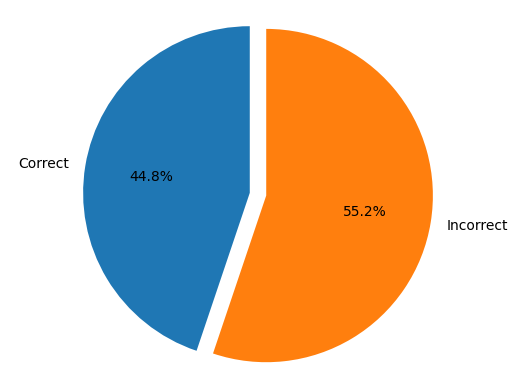

In [12]:
# Create a pie chart to visualize the correct and incorrect predictions

import matplotlib.pyplot as plt
import numpy as np

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Correct', 'Incorrect'
sizes = [len(df_correct), len(df_errors)]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Incorrect')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(path_static_all)
plt.show()

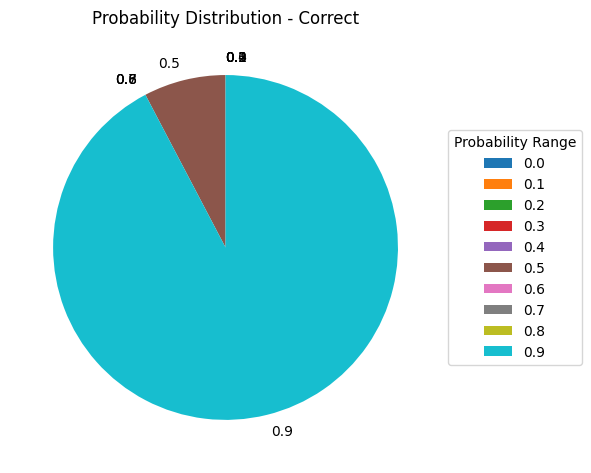

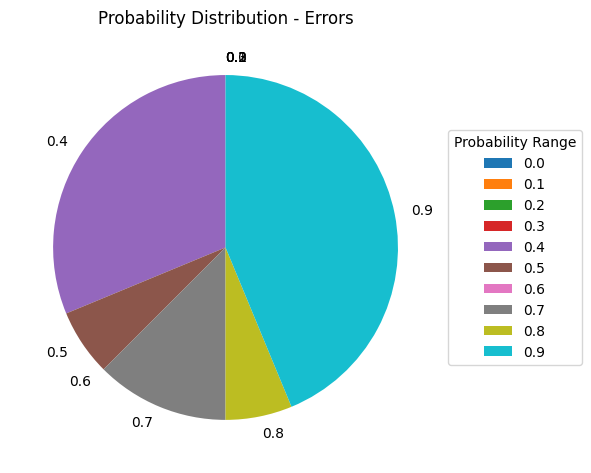

{0.0: '#9E0142', 0.1: '#D43D4F', 0.2: '#F46D43', 0.3: '#FDAD60', 0.4: '#FEE08B', 0.5: '#FFFFBE', 0.6: '#E6F598', 0.7: '#AADCA4', 0.8: '#66C2A5', 0.9: '#3387BC'}


In [13]:
import matplotlib
# Create the first plot for DATA 1
plt.figure(figsize=(6, 6))
plt.pie(percentage_distribution1, labels=probability_counts1.index, startangle=90)
plt.title('Probability Distribution - Correct')
plt.legend(percentage_distribution1.index, title="Probability Range", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.savefig(path_static_correct)
plt.show()

# Create the second plot for DATA 2
plt.figure(figsize=(6, 6))
plt.pie(probability_counts2, labels=probability_counts2.index, startangle=90)
plt.title('Probability Distribution - Errors')
plt.legend(probability_counts2.index, title="Probability Range", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.savefig(path_static_errors)
plt.show()

# Get the colors of the probability ranges
colors = [plt.cm.Spectral(i/float(len(probability_counts1.index))) for i in range(len(probability_counts1.index))]
# Get the HEX codes of the colors
hex_codes = [matplotlib.colors.rgb2hex(i).upper() for i in colors]
# Cast hex_codes to json file, the keys are the probability ranges
hex_codes = dict(zip(probability_counts1.index, hex_codes))
print(hex_codes)

In [14]:
# Convert dictionary keys to floats if needed
hex_codes = {float(key): value for key, value in hex_codes.items()}

# Apply lambda function to assign colors based on probability
df_results_id.loc[:, 'COLORS'] = df_results_id['PROBABILITY'].apply(lambda x: hex_codes.get(int(x * 10) % 10 / 10))
df_correct.loc[:, 'COLORS'] = df_correct['PROBABILITY'].apply(lambda x: hex_codes.get(int(x * 10) % 10 / 10))
df_errors.loc[:, 'COLORS'] = df_errors['PROBABILITY'].apply(lambda x: hex_codes.get(int(x * 10) % 10 / 10))

# Include the probability in the DataFrame
df_results_id.loc[:, 'PROBABILITY_VALUE'] = df_results_id['PROBABILITY'].apply(lambda x: int(x * 10) % 10 / 10)
df_correct.loc[:, 'PROBABILITY_VALUE'] = df_correct['PROBABILITY'].apply(lambda x: int(x * 10) % 10 / 10)
df_errors.loc[:, 'PROBABILITY_VALUE'] = df_errors['PROBABILITY'].apply(lambda x: int(x * 10) % 10 / 10)

/tmp/ipykernel_3073534/4225713839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct.loc[:, 'COLORS'] = df_correct['PROBABILITY'].apply(lambda x: hex_codes.get(int(x * 10) % 10 / 10))
/tmp/ipykernel_3073534/4225713839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_errors.loc[:, 'COLORS'] = df_errors['PROBABILITY'].apply(lambda x: hex_codes.get(int(x * 10) % 10 / 10))
/tmp/ipykernel_3073534/4225713839.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [15]:
df_errors.head()

,REAL_ID,PREDICTED_ID,PROBABILITY,ID_OFERTA,COLORS,PROBABILITY_VALUE
1,426,439,0.983664,680922729e4d1e8c4bb6e59b7aa935,#3387BC,0.9
2,436,2208,0.427822,a1ec170e2a4b15be5f75280d60427b,#FEE08B,0.4
3,436,426,0.800257,c9bec5a56d4698884c2e25495a64fe,#66C2A5,0.8
5,719,767,0.983766,fb048b57e041599b56992afb6a6d00,#3387BC,0.9
6,719,767,0.983766,032ed343594605885062cec6e4154c,#3387BC,0.9


In [16]:
# Save to results
df_results_id.to_csv(path_results_all, index=False)
df_correct.to_csv(path_results_correct, index=False)
df_errors.to_csv(path_results_incorrect, index=False)

In [44]:
from functions.tools import predict_incoming_offer
incoming_offer = {
    "CATEGORIA":"Profesiones, artes y oficios",
    "SUBCATEGORIA":"Carpintería",
    "PALABRAS_EMPLEO_TEXTO": "TECNICO CALIDAD EMPRESAS SECTOR ENERGIAS RENOVABLE EXPERIENCIA CONSTRUCCIONES PLANTAS SUBESTACIONES ELECTRICA RESPONSABLE SEGUIMIENTOS DOCUMENTACION PROYECTO CLIENTES COORDINACIONES DESARROLLO ELABORACION REVISION PROCEDIMIENTOS PROTOCOLOS TRABAJO SUPERVISAR GESTION ACTUALIZACION NORMATIVO PERSONAL APOYO MANTENIMIENTO MEJORA SISTEMA NORMAS ISO MEDIOAMBIENTE SEGURIDAD SALUD AUDITORIA FORMACIONES INGENIERA INDUSTRIAL CIVILES MASTER ENERGETICO INGLES OFFICE RESIDENCIA GEOGRAFICA CAPACIDAD LIDERAZGO EQUIPOS ORIENTACIONES RESULTADOS IDIOMAS "
}
predicted_id, probabilty = predict_incoming_offer(incoming_offer, vocabulary, model, dict_label_ids)
print(predicted_id)

1/1 [==============================] - 0s 62ms/step
636


In [45]:
# Assuming vector_test is a Pandas Series containing feature arrays
# Convert the first element of vector_test to a NumPy array and reshape it
index = 0
input_sample = np.array(vector_test[index]).reshape(1, -1)

# Predict the probability for the reshaped input sample
predictions = model.predict(input_sample)

# Get the class labels and their corresponding probabilities
class_labels = np.arange(min(train_labels), max(train_labels) + 1)
class_probabilities = predictions[0]

# Create a dictionary with labels as keys and probabilities as values
probabilities_dict = dict(zip(class_labels, class_probabilities))
# Now get the top 10 labels with the highest probabilities
top10_labels = dict(sorted(probabilities_dict.items(), key=lambda item: item[1], reverse=True)[:10])
print(top10_labels)
# Now get the label with the highest probability
highest_prob_label = max(probabilities_dict, key=probabilities_dict.get)
print(highest_prob_label)

1/1 [==============================] - 0s 24ms/step


{1: 0.8095238, 3: 0.13128905, 353: 0.034258086, 56: 0.008483502, 22: 0.0034422153, 24: 0.0025340067, 570: 0.0019313075, 25: 0.0019065547, 531: 0.0016856284, 5: 0.0008836311}
1


In [46]:
correct_predictions = 0
total_samples = len(vector_test)

for i, features in enumerate(vector_test):
    # Convert the features to a NumPy array and reshape it
    input_sample = np.array(features).reshape(1, -1)
    
    # Predict the probability for the reshaped input sample
    predictions = model.predict(input_sample)
    
    # Get the index of the class with the highest probability
    predicted_class = np.argmax(predictions)
    
    # Get the corresponding actual class label from vector_test_labels
    actual_class = test_labels[i]
    
    # Compare predicted and actual classes
    if predicted_class == actual_class:
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_samples
print("Accuracy:", accuracy)


1/1 [==============================] - 0s 22ms/step


KeyboardInterrupt: 

In [ ]:
import numpy as np

# Assuming vector_test is a Pandas Series containing feature arrays
# and vector_test_labels is a list of actual class labels

# Convert vector_test to a NumPy array
vector_test_array = np.vstack(vector_test)

# Predict class probabilities for all samples in vector_test
predictions = model.predict(vector_test_array)

# Get the predicted classes for each sample
predicted_classes = np.argmax(predictions, axis=1)

# Convert vector_test_labels to a NumPy array
vector_test_labels_array = np.array(test_labels + 12)

# Compare predicted classes with actual classes
correct_predictions = np.sum(predicted_classes == vector_test_labels_array)

# Calculate accuracy
accuracy = correct_predictions / len(vector_test)
print("Accuracy:", accuracy)

15/15 [==============================] - 0s 2ms/step
Accuracy: 0.0


2023-08-08 09:56:08.516854: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17506128 exceeds 10% of free system memory.


In [ ]:
print(len(vector_test_array[0]))
print(predicted_classes[0])

4646
45
